## ENSF 612 - Assignment 2
### Author: Steven Duong (30022492)

In [0]:
%pip install bs4
%pip install nltk

Python interpreter will be restarted.
  Created wheel for bs4: filename=bs4-0.0.1-py3-none-any.whl size=1271 sha256=6938f6d377721142e86325627f2b7febfba1b4e74c1511a071e1cb6fe39d6c52
  Stored in directory: /root/.cache/pip/wheels/73/2b/cb/099980278a0c9a3e57ff1a89875ec07bfa0b6fcbebb9a8cad3
Successfully built bs4
Python interpreter will be restarted.
Python interpreter will be restarted.
Python interpreter will be restarted.


### Question 1 & 2 
### Preprocessing Each Data File and Plotting the Frequent/Top Keywords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Top 10 Keywords in SO-Spark:
+---------+-----+
|     word|count|
+---------+-----+
|    spark|64586|
|     data|34261|
|    using|31670|
|     code|23904|
|     like|23266|
|    error|21873|
|     file|21016|
|dataframe|19949|
|     want|17735|
|      use|16961|
+---------+-----+



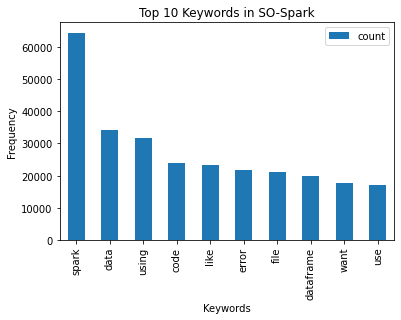

Top 10 Keywords in SO-ML:
+--------+-----+
|    word|count|
+--------+-----+
|    data|42365|
|   model|40373|
|   using|32282|
|    code|27731|
|     use|22369|
|training|22105|
|    like|20871|
|   error|20636|
|   would|17748|
|     get|17285|
+--------+-----+



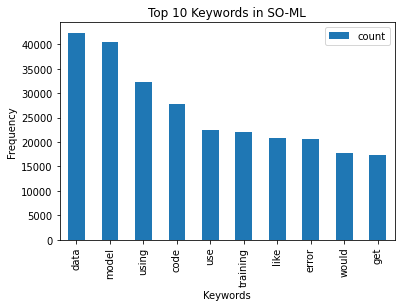

Top 10 Keywords in SO-Security:
+-----------+-----+
|       word|count|
+-----------+-----+
|       user|40176|
|      using|30729|
|   security|29773|
|     server|28268|
|        use|25499|
|      would|24580|
|       like|23022|
|       code|22733|
|application|21329|
|     access|20546|
+-----------+-----+



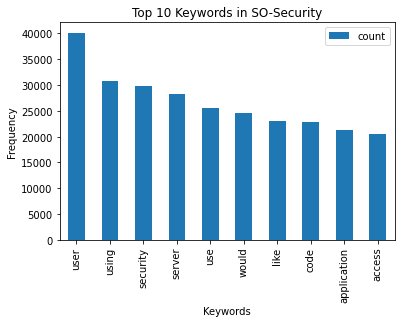

In [0]:
import matplotlib.pyplot as plt
import pandas as pd
import re
import nltk
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, split, explode, count
from pyspark.sql.types import StringType
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
nltk.download("stopwords")

# initialize Spark
spark = SparkSession.builder.appName("StackOverflowAnalysis").getOrCreate()

# Function to load the CSV files.
def load_csv(filename):
    df = spark.read.format("csv").option("header", "true").option("multiline", "true").option('escape', "\"").load(filename)
    return df

from nltk.corpus import stopwords
from bs4 import BeautifulSoup
import re

def preprocess_text(text):
    # Parse HTML content using bs4
    soup = BeautifulSoup(text, "html.parser")
 
    # Decompose the code tag
    for code in soup.find_all("code"):
        code.decompose()
 
    # Extract all other tags
    tags = soup.find_all()
 
    # Extract text from tags
    text = ""
    for tag in tags:
        if tag.name in ["p", "h1", "h2", "h3", "h4", "h5", "h6", "ul", "ol", "li", "a", "strong", "em", "span", "blockquote", "div"]:
            text += tag.get_text() + " "
 
    # Change all words to lower case
    text = text.lower()
 
    # Remove all punctuation marks
    text = re.sub(r'[^\w\s]', '', text)
 
    # Remove all non-alphabetic characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)
 
    # Remove stop words, and adding 'im' to the list of nltk stopwords
    stop_words = set(stopwords.words('english'))
    stop_words.add('im')
    text = ' '.join([word for word in text.split() if word not in stop_words])
 
    return text

# Register user-defined function (UDF) for preprocessing
preprocess_udf = udf(preprocess_text, StringType())
    
# Loading the three CSV files.
so_spark = load_csv("/FileStore/tables/SO_Spark.csv")
so_ml = load_csv("/FileStore/tables/SO_ML.csv")
so_security = load_csv("/FileStore/tables/SO_Security.csv")

# Apply preprocessing function to each file
so_spark_pre = so_spark.select(explode(split(preprocess_udf("Body"), "\s+")).alias("word"))
so_ml_pre = so_ml.select(explode(split(preprocess_udf("Body"), "\s+")).alias("word"))
so_security_pre = so_security.select(explode(split(preprocess_udf("Body"), "\s+")).alias("word"))

# Define function to find top keywords and visualize them using a bar chart
def top_keywords(df, filename):
    # Preprocess the text in the "Body" column
    preprocessed_text = df.select(explode(split(preprocess_udf("Body"), "\s+")).alias("word"))
    
    # Count the frequency of each word
    top_keywords = (preprocessed_text
                    .groupBy("word")
                    .agg(count("*").alias("count"))
                    .orderBy("count", ascending=False)
                    .limit(10))
    
    # Display the top keywords in a dataframe
    print(f"Top 10 Keywords in {filename}:")
    top_keywords.show()
    
    # Convert to Pandas DataFrame and visualize with a bar chart
    top_keywords_pd = top_keywords.toPandas()
    top_keywords_pd.plot(kind="bar", x="word", y="count")
    plt.title(f"Top 10 Keywords in {filename}")
    plt.xlabel("Keywords")
    plt.ylabel("Frequency")
    plt.show()
    
    return top_keywords

# Find top keywords and visualize them for each file
top_spark = top_keywords(so_spark, "SO-Spark")
top_ml = top_keywords(so_ml, "SO-ML")
top_security = top_keywords(so_security, "SO-Security")


Overall Top 30 Keywords:
            word  count
0          data  95853
1         using  94681
2          code  74368
3          like  67159
4         spark  65629
5           use  64829
6         would  55461
7          want  51364
8         error  50505
9           get  49342
10         file  49233
11         user  45252
12          one  44427
13        model  44154
14          way  42749
15       trying  35636
16    following  35563
17         need  35381
18         know  32414
19       server  31493
20      problem  30785
21          set  30073
22     security  29971
23  application  29181
24         also  28968
25     function  28464
26      example  28085
27        could  26810
28        tried  26684
29          run  26008


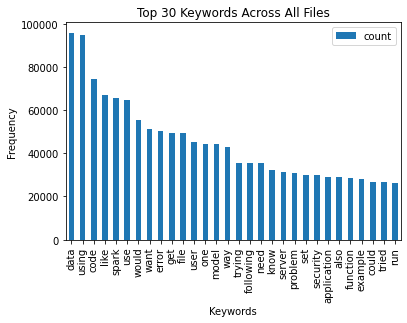

In [0]:
# Combine all three dataframes into one
so_combined = so_spark_pre.union(so_ml_pre).union(so_security_pre)

# Define a function to find the top 30 keywords across all files
def top_keywords_combined(df):
    # Count the frequency of each word
    top_keywords = (df
                    .groupBy("word")
                    .agg(count("*").alias("count"))
                    .orderBy("count", ascending=False)
                    .limit(30))
    
    return top_keywords

# Find the top 30 keywords across all files
overall_top_30 = top_keywords_combined(so_combined)

# Convert to Pandas DataFrame and display
overall_top_30_pd = overall_top_30.toPandas()
print("Overall Top 30 Keywords:\n", overall_top_30_pd)

# Visualize with a bar chart
overall_top_30_pd.plot(kind="bar", x="word", y="count")
plt.title("Top 30 Keywords Across All Files")
plt.xlabel("Keywords")
plt.ylabel("Frequency")
plt.show()


### Question 3
### Percentage of Questions That Does Not Have an Accepted Answer

In [0]:
# Function to show the percentage of questions without accepted answer for each file
def unanswered_questions_percentage(df, filename):
    total_questions = df.count()
    unanswered_questions = df.filter("AcceptedAnswerId is NULL").count()
    percentage = (unanswered_questions / total_questions) * 100
    return pd.DataFrame({'File Name': filename, 'Percentage of Unanswered Questions': [percentage]})
  
# Create a list of DataFrames containing the percentage of unanswered questions for each file
percentage_df_list = [unanswered_questions_percentage(so_spark, "SO-Spark"),
                      unanswered_questions_percentage(so_ml, "SO-ML"),
                      unanswered_questions_percentage(so_security, "SO-Security")]

# Combine the DataFrames into a single result DataFrame
result_df = pd.concat(percentage_df_list)

# Set the precision of the percentage column to 2 decimal places
result_df['Percentage of Unanswered Questions'] = result_df['Percentage of Unanswered Questions'].apply(lambda x: f'{x:.2f}%')

# Display the result DataFrame
display(result_df)

File Name,Percentage of Unanswered Questions
SO-Spark,56.65%
SO-ML,57.07%
SO-Security,47.47%


### Question 4
### The Total Amount of Posts Created by Year

Posts created by year in SO-Spark:
+----+-----+
|year|count|
+----+-----+
|2011|    1|
|2012|    2|
|2013|   61|
|2014| 1203|
|2015| 5102|
|2016| 7985|
|2017| 8285|
|2018| 4401|
|2019| 8770|
|2020| 7092|
|2021| 3112|
|2022| 3986|
+----+-----+



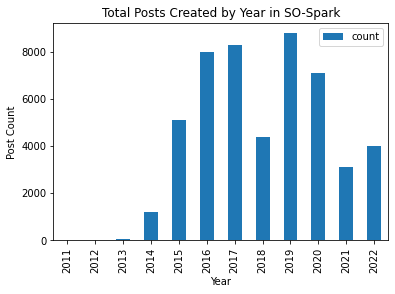

Posts created by year in SO-ML:
+----+-----+
|year|count|
+----+-----+
|2008|    9|
|2009|   94|
|2010|  295|
|2011|  504|
|2012| 1032|
|2013| 1500|
|2014| 1731|
|2015| 2618|
|2016| 4720|
|2017| 6776|
|2018| 6908|
|2019| 6548|
|2020| 7808|
|2021| 5172|
|2022| 4285|
+----+-----+



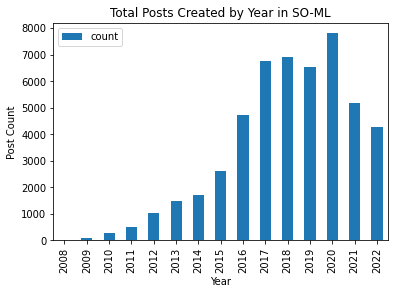

Posts created by year in SO-Security:
+----+-----+
|year|count|
+----+-----+
|2008|  635|
|2009| 2563|
|2010| 3955|
|2011| 5303|
|2012| 5452|
|2013| 5528|
|2014| 5167|
|2015| 4440|
|2016| 3612|
|2017| 3339|
|2018| 2070|
|2019| 2182|
|2020| 2787|
|2021| 1405|
|2022| 1562|
+----+-----+



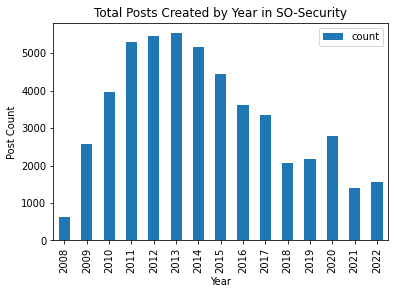

In [0]:
from pyspark.sql.functions import year

# Function to show the total amount of posts created by year and visualize it with a bar chart
def posts_by_year(df, filename):
    # Extract year from CreationDate column
    df = df.withColumn("year", year("CreationDate"))
    # Count posts by year
    posts_by_year = (df.groupBy("year")
                     .agg(count("*").alias("count"))
                     .orderBy("year"))
    
    # Display and Convert to Pandas DataFrame
    print(f"Posts created by year in {filename}:")
    posts_by_year.show()
    posts_by_year_pd = posts_by_year.toPandas()
    
    # Visualize with a bar chart
    posts_by_year_pd.plot(kind="bar", x="year", y="count")
    plt.title(f"Total Posts Created by Year in {filename}")
    plt.xlabel("Year")
    plt.ylabel("Post Count")
    plt.show()

# Show the total amount of posts created by year for each file
posts_by_year(so_spark, "SO-Spark")
posts_by_year(so_ml, "SO-ML")
posts_by_year(so_security, "SO-Security")
